In [1]:
from src.hks import HierarchicalPermutationTest

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

---
##### **Using the HKS test in real fMRI data**

In [2]:
data = sns.load_dataset('fmri')
data.head(5)

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970


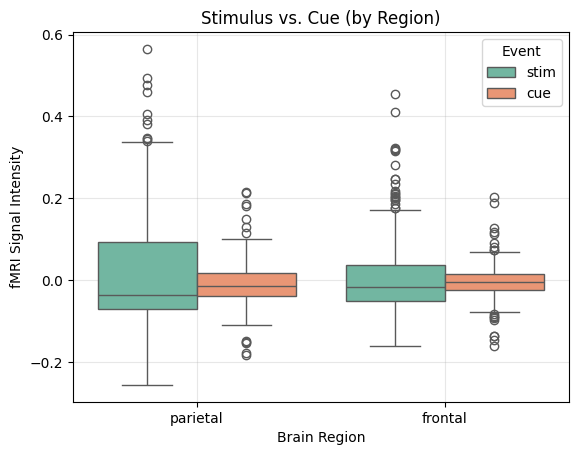

In [ ]:
sns.boxplot(data = data, x = 'region', y = 'signal', hue = 'event', palette = 'Set2')

plt.title('Stimulus vs. Cue (by Region)')
plt.xlabel('Brain Region')
plt.ylabel('fMRI Signal Intensity')
plt.grid(True, alpha = 0.3)
plt.legend(title = 'Event')

plt.show()

In [4]:
categorical = ['subject', 'event', 'region', 'timepoint']
for cols in categorical:
    print(pd.unique(data[cols]).tolist())

['s13', 's5', 's12', 's11', 's10', 's9', 's8', 's7', 's6', 's4', 's3', 's2', 's1', 's0']
['stim', 'cue']
['parietal', 'frontal']
[18, 14, 17, 9, 16, 15, 0, 13, 12, 11, 10, 3, 7, 8, 2, 6, 5, 4, 1]


We split the dataset by brain region (Frontal vs. Parietal) to analyze them independently. The goal is to compare the fMRI signal distribution between two events: Stimulus vs Cue.

**Hierarchical Logic:** Since this dataset contains a single time-series recording per subject (per condition), we map the hierarchy as follows: 1 Subject = 1 Unit (Cell). The variability comes from the 19 timepoints recorded within that single unit.

Data Hierarchy:
* **Group:** Event (stim, cue)
* **Subject:** Subject ID (s0 to s13)
* **Unit (Cell):** Mapped to Subject ID (since there is 1 recording per subject)
* **Observations:** Timepoints (0 to 18)

In [5]:
# ------------------------------ 1. Frontal Region ------------------------------

"""
We create a 'unique_subject_id' to split the data by condition. This ensures that 
the hierarchical sampler sees two distinct subject (e.g., 's0_stim vs. 's0_cue') each 
with 19 timepoints, rather than a single subject 's0' with 38 mixed timepoints.

"""

data_frontal = data[data['region'] == 'frontal'].copy()
data_frontal['unique_subject_id'] = data_frontal['subject'] + "_" + data_frontal['event']
data_frontal['recording_id'] = data_frontal['unique_subject_id']

data_frontal.head(5)

,subject,timepoint,event,region,signal,unique_subject_id,recording_id
67,s0,0,stim,frontal,-0.021452,s0_stim,s0_stim
170,s2,6,stim,frontal,0.101050,s2_stim,s2_stim
267,s10,4,stim,frontal,0.030044,s10_stim,s10_stim
268,s11,4,stim,frontal,0.075957,s11_stim,s11_stim
269,s3,0,stim,frontal,0.011056,s3_stim,s3_stim


In [6]:
"""
We enable sampling with replacement because the sample size (19) equals the total available 
observations per subject. Without replacement, every resample would be identical, resulting 
in zero variance and a degenerate observed observed distribution (a "spike" in the plot).

Note: Even if we used 'replace = False' (resulting in the visual "spike"), the test remains 
statistically valid. The p-value would still be correctly computed by comparing the exact observed 
statistic against the null distribution.

"""

hks_frontal = HierarchicalPermutationTest(df = data_frontal,
                                          value_col = 'signal',
                                          group_col = 'event',
                                          subject_col = 'unique_subject_id',
                                          cell_col = 'recording_id',
                                          metric = 'ks',
                                          replace = True)

p_frontal = hks_frontal.run(n_resamples = 100000, n_permutations = 100000, random_state = 123)

INFO: Auto-detected n_obs_per_cell = 19 (minimum number across the entire dataset).
INFO: Auto-detected n_cells_per_subject = 1 (minimum number across the entire dataset).
INFO: Optimizing data structure for fast resampling...
Calculating Observed Distribution (100000 resamples)...


Observed: 100%|██████████| 100000/100000 [00:19<00:00, 5110.85it/s]


Calculating Null Distribution (100000 permutations)...


Null: 100%|██████████| 100000/100000 [00:18<00:00, 5296.64it/s]


HKS P-Value (Frontal - Stim vs. Cue): 0.05354


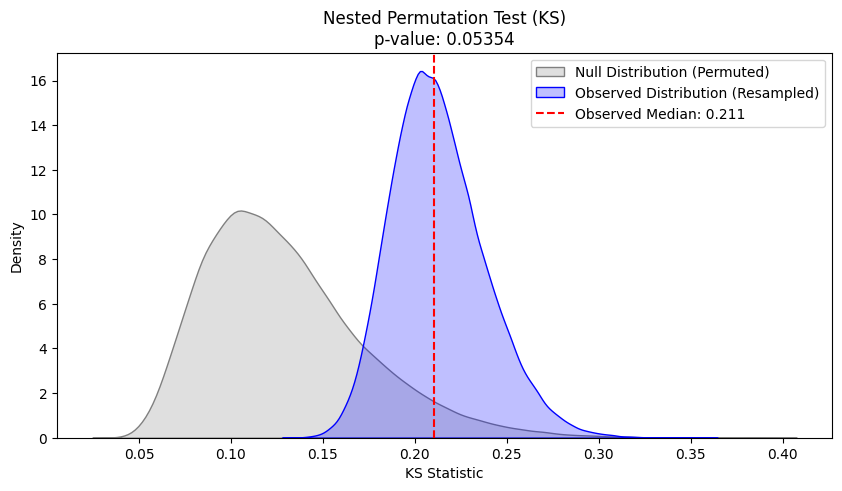

In [7]:
print(f"HKS P-Value (Frontal - Stim vs. Cue): {p_frontal}")
hks_frontal.plot_results()

In [8]:
# ------------------------------ 2. Parietal Region ------------------------------

data_parietal = data[data['region'] == 'parietal'].copy()
data_parietal['unique_subject_id'] = data_parietal['subject'] + "_" + data_parietal['event']
data_parietal['recording_id'] = data_parietal['unique_subject_id']

data_parietal.head(5)

,subject,timepoint,event,region,signal,unique_subject_id,recording_id
0,s13,18,stim,parietal,-0.017552,s13_stim,s13_stim
1,s5,14,stim,parietal,-0.080883,s5_stim,s5_stim
2,s12,18,stim,parietal,-0.081033,s12_stim,s12_stim
3,s11,18,stim,parietal,-0.046134,s11_stim,s11_stim
4,s10,18,stim,parietal,-0.037970,s10_stim,s10_stim


In [9]:
hks_parietal = HierarchicalPermutationTest(df = data_parietal,
                                           value_col = 'signal',
                                           group_col = 'event',
                                           subject_col = 'unique_subject_id',
                                           cell_col = 'recording_id',
                                           metric = 'ks',
                                           replace = True)

p_parietal = hks_parietal.run(n_resamples = 100000, n_permutations = 100000, random_state = 123)

INFO: Auto-detected n_obs_per_cell = 19 (minimum number across the entire dataset).
INFO: Auto-detected n_cells_per_subject = 1 (minimum number across the entire dataset).
INFO: Optimizing data structure for fast resampling...
Calculating Observed Distribution (100000 resamples)...


Observed: 100%|██████████| 100000/100000 [00:13<00:00, 7365.49it/s]


Calculating Null Distribution (100000 permutations)...


Null: 100%|██████████| 100000/100000 [00:15<00:00, 6637.28it/s]


HKS P-Value (Parietal - Stim vs. Cue): 0.00124


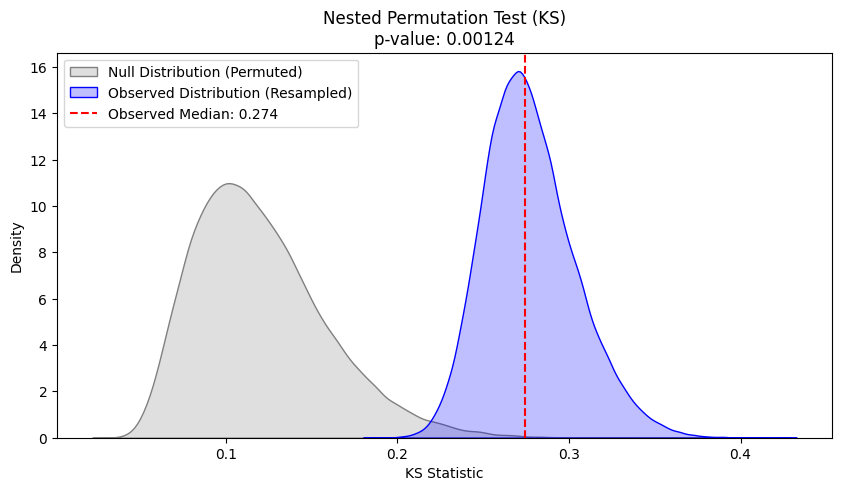

In [10]:
print(f"HKS P-Value (Parietal - Stim vs. Cue): {p_parietal}")
hks_parietal.plot_results()

This brief analysis demonstrates that the fMRI signal in the parietal region varies significantly between 'stim' and 'cue' events across the 13 subjects and their repeated measures. While simpler analytical approaches could be applied to this dataset, this document serves primarily as a minimal example to illustrate the features of this statistical analysis on experimental data.